# Functional RMI as 3D Point Cloud classification

Using PointNet

In [1]:
path = ".."

import os
import sys
sys.path.insert(0, path)

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [2]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [3]:
fmri_cols = [c for c in data_train_.columns if "fmri" in c]
fmri_cols

['fmri_basc064',
 'fmri_basc122',
 'fmri_basc197',
 'fmri_craddock_scorr_mean',
 'fmri_harvard_oxford_cort_prob_2mm',
 'fmri_motions',
 'fmri_msdl',
 'fmri_power_2011',
 'fmri_select']

In [6]:
accepted_fmri = data_train_['fmri_select'] > 0

### Altas Power 2011 time series to 3D ROI sequences

In [5]:
from nilearn import datasets
atlas = datasets.fetch_coords_power_2011()

In [7]:
rois = atlas.rois
# rois

In [41]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)


data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)

accepted_fmri = data_train['fmri_select'] > 0

data1_train = data_train.loc[accepted_fmri, :]
is_asd = data1_train['target'] > 0

In [8]:
# from nilearn.signal import clean

# idx = data1_train.index[0]
# path_motions = os.path.join(path, data1_train.loc[idx, 'fmri_motions'])
# confounds = np.loadtxt(path_motions)
# path_fmri_atlas = os.path.join(path, data1_train.loc[idx, 'fmri_power_2011'])
# timeseries = pd.read_csv(path_fmri_atlas, header=None).values
# cleaned_timeseries = clean(timeseries, confounds=confounds)

# cleaned_timeseries.shape

# output = np.zeros((len(x_roi_to_index), len(y_roi_to_index), len(z_roi_to_index)))

# for i, v in enumerate(tp):
#     ix = x_roi_to_index[rois[i].x]
#     iy = y_roi_to_index[rois[i].y]
#     iz = z_roi_to_index[rois[i].z]
#     output[ix, iy, iz] = v

In [9]:
# plt.imshow(output.sum(2))

Datasets

In [2]:
from functools import lru_cache

import numpy as np

from torch.utils.data import Dataset

from nilearn.signal import clean


class fRMITimeSeriesDataset(Dataset):
    
    def __init__(self, data_df, labels, fmri_type, path):
        assert fmri_type in [c for c in data_df.columns if "fmri" in c]
        self.df = data_df
        self.targets = labels
        self.fmri_type = fmri_type
        self.path = path
        
    def __len__(self):
        return len(self.targets)

    @lru_cache(maxsize=1024)
    def __getitem__(self, i):
        idx = self.df.index[i]
        path_motions = os.path.join(self.path, self.df.loc[idx, 'fmri_motions'])
        confounds = np.loadtxt(path_motions)
        path_fmri_atlas = os.path.join(self.path, self.df.loc[idx, self.fmri_type])
        timeseries = pd.read_csv(path_fmri_atlas, header=None).values
        cleaned_timeseries = clean(timeseries, confounds=confounds)
        return cleaned_timeseries, self.targets[i]
    

class fRMI3DPointCloudDataset(Dataset):
    pass
    
    
    
class TransformedDataset(Dataset):
    
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        return self.transform(self.ds[index])

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [4]:
from sklearn.model_selection import StratifiedKFold

seed = 17
n_splits = 7

splt = StratifiedKFold(n_splits=n_splits, random_state=seed)

pipes = []
X_test = data_test_
y_test = labels_test_


train_indices, val_indices = next(splt.split(data_train_, labels_train_))

train_idx = data_train_.index[train_indices]
val_idx = data_train_.index[val_indices]

train_dataset = fMRIDataset(data_train_.loc[train_idx, :], labels_train_[train_indices], 'fmri_power_2011', path)
val_dataset = fMRIDataset(data_train_.loc[val_idx, :], labels_train_[val_indices], 'fmri_power_2011', path)

In [26]:
from torchvision.transforms import Compose, ToTensor, Normalize

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.0, ], std=[5.0, ])
])


max_heigth = 180


def data_transform(dp):
    img, t = dp
    # crop or pad to (180, 264)
    h, w = img.shape
    if h < max_heigth:
        n_img = np.pad(img, ((0, max_heigth - h), (0, 0)), mode='constant')    
    else:
        n_img = img[:max_heigth, :]
    n_img = np.expand_dims(n_img, axis=-1).astype(np.float32)
    n_img = img_transform(n_img)
    return n_img, t    

In [27]:
from torch.utils.data import DataLoader

train_tf_dataset = TransformedDataset(train_dataset, transform=data_transform)
val_tf_dataset = TransformedDataset(val_dataset, transform=data_transform)

train_loader = DataLoader(train_tf_dataset, batch_size=16, num_workers=12, shuffle=True)
val_loader = DataLoader(val_tf_dataset, batch_size=16, num_workers=12, shuffle=False)

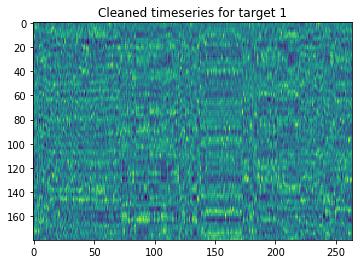

In [28]:
dp = train_tf_dataset[133]
plt.title("Cleaned timeseries for target {}".format(dp[1]))
plt.imshow(dp[0].numpy()[0, :, :])

In [29]:
for batch in train_loader:
    pass

for batch in val_loader:
    pass

Model

In [30]:
import torch.nn as nn


In [39]:
stem = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
    nn.Conv2d(32, 32, kernel_size=(1, 11), stride=(1, 1), padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=1),
    nn.Conv2d(32, 32, kernel_size=(1, 7), stride=(1, 1), padding=0),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2)
)

In [40]:
dp[0].unsqueeze(0).shape

torch.Size([1, 1, 180, 264])

In [41]:
stem(dp[0].unsqueeze(0)).shape

torch.Size([1, 32, 90, 125])

In [63]:
import torch.nn as nn


class fMRI_ASD_Classification(nn.Module):
    
    def __init__(self):
        super(fMRI_ASD_Classification, self).__init__()
        
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(32, 32, kernel_size=(1, 11), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(32, 32, kernel_size=(1, 7), stride=(1, 1), padding=0),           
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.features = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(64, 64, kernel_size=(1, 7), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(64, 64, kernel_size=(1, 7), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv1d(64, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(128, 128, kernel_size=(1, 7), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(128, 128, kernel_size=(1, 7), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv1d(128, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv1d(256, 512, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(512, 512, kernel_size=(1, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv1d(512, 512, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(512, 512, kernel_size=(1, 3), stride=(1, 1), padding=0),            
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)            
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(2560, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)            
        )        
        
    def forward(self, x):        
        f = self.stem(x)
        f = self.features(f)
        f = f.view(f.shape[0], -1)
        y = self.classifier(f)
        return y

In [80]:
from torch.optim import SGD


model = fMRI_ASD_Classification()
optimizer = SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [81]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import CategoricalAccuracy, Loss


trainer = create_supervised_trainer(model, optimizer, criterion)

metrics = {
    'loss': Loss(criterion),
    'accuracy': CategoricalAccuracy(),
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics)
val_evaluator = create_supervised_evaluator(model, metrics=metrics)

In [82]:
log_interval = 10

@trainer.on(Events.ITERATION_COMPLETED)
def log_training(engine):
    iteration = engine.state.iteration
    if iteration % log_interval == 0:
        print("Training Epoch {} | Iteration {} | Loss {}"
              .format(engine.state.epoch, engine.state.iteration, engine.state.output))    

In [83]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_metrics(engine):
    print("Start evaluation on train dataset ...")
    train_metrics = train_evaluator.run(train_loader).metrics
    for name in train_metrics:
        print("{} : {}".format(name, train_metrics[name]))
        

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_metrics(engine):
    print("Start evaluation on validation dataset ...")
    val_metrics = val_evaluator.run(val_loader).metrics
    for name in val_metrics:
        print("{} : {}".format(name, val_metrics[name]))        

In [84]:
trainer.run(train_loader, max_epochs=10)

Process Process-70:
Process Process-63:
Process Process-72:
Process Process-62:
Process Process-71:
Process Process-68:
Process Process-69:
Process Process-66:
Process Process-61:
Process Process-64:
Process Process-65:
Process Process-67:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
 

KeyboardInterrupt
  File "/opt/conda/envs/rampwf/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
KeyboardInterrupt
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/envs/rampwf/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt

KeyboardInterrupt: 